# Assignment 1: Least Squares
## Name: Barun Parua
## Roll Number: 21CS10014

## Imports
Here is the list of all the libraries used in this assignment.

In [364]:
# imports
from torchvision.datasets import MNIST
import numpy as np
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## MNIST Dataset

Here, the MNIST dataset is downloaded and stored separately for training and test data, hence no further splitting is required. 

In [365]:
# fetching and loading the MNIST dataset
mnist_data_train = MNIST('/', train=True, download=True)
mnist_data_test = MNIST('/', train=False, download=True)

## Least Squares Function

Main function of the assignment.

This is the function that calculates the least squares solution for a given matrix A and vector b. It returns the vector x that minimizes the 2-norm of Ax-b.

x is based on the formula: x = inv(A.T @ A) @ A.T @ b

Note that here I have used the @ operator to denote matrix multiplication. Also, the transpose of a matrix A is denoted by A.T. Finally, inv(A) denotes the inverse of a matrix A. Here I have used the pinv function from numpy.linalg to calculate the pseudo-inverse of A, rather than the inverse of A so that the function can handle non-square and singular matrices. (However, A.T @ A is always square and invertible, so this is not necessary here.)

In [366]:
def least_squares(A, b):
    x = np.linalg.pinv(A.T @ A) @ A.T @ b
    return x

## Question 1

The MNIST dataset is loaded already above. Now, we have to filter the dataset to only include classes 1 and 7 and assign them labels 1 and -1 respectively. After this the images are flattened from matrices of size 28x28 to vectors of length 784. Then, using the least squares function we train the model on train set and report the accuracy and the confusion matrix on the test set.

It can be seen that the accuracy is very high, and the confusion matrix shows that the model is able to distinguish between 1 and 7 very well.

In [367]:
# function to filter the dataset to only include 1s and 7s as per the assignment
def filter_dataset(dataset):
    indices = (dataset.targets == 1) | (dataset.targets == 7)
    images = dataset.data[indices]
    labels = dataset.targets[indices]
    return images, labels

print("Shapes of the train and test data before filtering:", mnist_data_train.data.shape, mnist_data_test.data.shape)

# applying the filter to get the test and train data
X_train, y_train = filter_dataset(mnist_data_train)
X_test, y_test = filter_dataset(mnist_data_test)

# assigning the labels to 1 if class is 1 and -1 if class is 7
y_train = np.where(y_train == 1, 1, -1)
y_test = np.where(y_test == 1, 1, -1)

print(f"Shapes of X_train and X_test before flattening: {X_train.shape}, {X_test.shape}")

# vectorizing the images
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0
print(f"Shapes of X_train and X_test after flattening: {X_train.shape}, {X_test.shape}\n")

# adding a column of 1s to the data for the bias term
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# training the model to get the weights
weights = least_squares(X_train, y_train)

# predicting the labels for the test data
y_pred = np.sign(X_test @ weights)

# reporting the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}\n\nConfusion Matrix:")

# plotting the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)


Shapes of the train and test data before filtering: torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
Shapes of X_train and X_test before flattening: torch.Size([13007, 28, 28]), torch.Size([2163, 28, 28])
Shapes of X_train and X_test after flattening: torch.Size([13007, 784]), torch.Size([2163, 784])



Accuracy: 0.9894

Confusion Matrix:
Predicted  -1.0   1.0
Actual               
-1         1007    21
 1            2  1133


## Question 2

The MNIST dataset is loaded already above. Now, the images are flattened from matrices of size 28x28 to vectors of length 784. Then, using the least squares function we train the model on train set and report the accuracy and the confusion matrix on the test set.

For each class, we have to train a separate model. Fpr this, we select samples of the current class as positive samples and randomly select equal number of samples from the other classes as negative samples to make the dataset balanced. Now using the least squares function we train the model on train set for each of the classes.

Now, we have to predict the class of each test sample by using the model that gives the highest score of prediction for that sample and assigning the sample to that class. Finally we report the accuracy and the confusion matrix on the test set.

This part is a bit lengthy code wise, but execution wise it is fast enough. Therefore I request you to please run the code once and go through the comments to understand the code.

In [385]:
# define the training and test sets
X_train, y_train = np.array(mnist_data_train.data), np.array(mnist_data_train.targets)
X_test, y_test = np.array(mnist_data_test.data), np.array(mnist_data_test.targets)

# shuffle the data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]

# vectorizing the images
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# define a function to filter the dataset to only include class i images for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def filter_dataset(train_x, train_y, class_label):
    indices = (train_y == class_label)
    images = train_x[indices]
    labels = train_y[indices]
    return images, labels

# define a function to select all images except those of class i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def filter_dataset_not(train_x, train_y, class_label):
    indices = (train_y != class_label)
    images = train_x[indices]
    labels = train_y[indices]
    return images, labels

def train_wrt_class(class_label):
    # class label is the label of the class for which the model is being trained
    # take the images of class and randomly sample the same number of images from the rest of the dataset
    X_train_0, y_train_0 = filter_dataset(X_train, y_train, class_label)
    X_train_0_not, y_train_0_not = filter_dataset_not(X_train, y_train, class_label)

    # randomly sample the same number of images from the rest of the dataset
    indices = np.random.choice(np.arange(len(X_train_0_not)), len(X_train_0))
    X_train_0_not = X_train_0_not[indices]
    y_train_0_not = y_train_0_not[indices]

    # add the images of class 0 and the randomly sampled images from the rest of the dataset
    X_train_0 = np.concatenate((X_train_0, X_train_0_not))
    y_train_0 = np.concatenate((y_train_0, y_train_0_not))

    print(f"Shapes of X_train_0 and y_train_0 after filtering and sampling: {X_train_0.shape}, {y_train_0.shape}")

    # assign the labels to 1 if class is class_label and -1 if class is not class_label
    y_train_0 = np.where(y_train_0 == class_label, 1, -1)
    y_test_0 = np.where(y_test == class_label, 1, -1)

    # train the model to get the weights
    weights_0 = least_squares(X_train_0, y_train_0)

    # predict the labels for the test data
    y_pred_0 = np.sign(X_test @ weights_0)

    # report the accuracy of the model
    accuracy_0 = np.mean(y_pred_0 == y_test_0)
    print(f"\nAccuracy for class {class_label}: {accuracy_0:.4f}\n\nConfusion Matrix for class {class_label}:")

    # plot the confusion matrix
    confusion_matrix_0 = pd.crosstab(y_test_0, y_pred_0, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix_0)
    
    return weights_0

### Class 0

Training of the model for class 0.

In [386]:
# class 0
weights_0 = train_wrt_class(0)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11846, 784), (11846,)

Accuracy for class 0: 0.9710

Confusion Matrix for class 0:
Predicted  -1.0   1.0
Actual               
-1         8742   278
 1           12   968


### Class 1

Training of the model for class 1.

In [387]:
# class 1
weights_1 = train_wrt_class(1)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (13484, 784), (13484,)

Accuracy for class 1: 0.9662

Confusion Matrix for class 1:
Predicted  -1.0   1.0
Actual               
-1         8540   325
 1           13  1122


### Class 2

Training of the model for class 2.

In [388]:
# class 2
weights_2 = train_wrt_class(2)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11916, 784), (11916,)

Accuracy for class 2: 0.9475

Confusion Matrix for class 2:
Predicted  -1.0   1.0
Actual               
-1         8524   444
 1           81   951


### Class 3

Training of the model for class 3.

In [389]:
# class 3
weights_3 = train_wrt_class(3)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (12262, 784), (12262,)

Accuracy for class 3: 0.9226

Confusion Matrix for class 3:
Predicted  -1.0   1.0
Actual               
-1         8269   721
 1           53   957


### Class 4

Training of the model for class 4.

In [390]:
# class 4
weights_4 = train_wrt_class(4)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11684, 784), (11684,)

Accuracy for class 4: 0.9338

Confusion Matrix for class 4:
Predicted  -1.0   1.0
Actual               
-1         8381   637
 1           25   957


### Class 5

Training of the model for class 5.

In [391]:
# class 5
weights_5 = train_wrt_class(5)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (10842, 784), (10842,)

Accuracy for class 5: 0.9105

Confusion Matrix for class 5:
Predicted  -1.0   1.0
Actual               
-1         8265   843
 1           52   840


### Class 6

Training of the model for class 6.

In [392]:
# class 6
weights_6 = train_wrt_class(6)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11836, 784), (11836,)

Accuracy for class 6: 0.9599

Confusion Matrix for class 6:
Predicted  -1.0   1.0
Actual               
-1         8672   370
 1           31   927


### Class 7

Training of the model for class 7.

In [393]:
# class 7
weights_7 = train_wrt_class(7)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (12530, 784), (12530,)

Accuracy for class 7: 0.9541

Confusion Matrix for class 7:
Predicted  -1.0   1.0
Actual               
-1         8561   411
 1           48   980


### Class 8

Training of the model for class 8.

In [394]:
# class 8
weights_8 = train_wrt_class(8)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11702, 784), (11702,)

Accuracy for class 8: 0.8532

Confusion Matrix for class 8:
Predicted  -1.0   1.0
Actual               
-1         7649  1377
 1           91   883


### Class 9

Training of the model for class 9.

In [395]:
# class 9
weights_9 = train_wrt_class(9)

Shapes of X_train_0 and y_train_0 after filtering and sampling: (11898, 784), (11898,)

Accuracy for class 9: 0.8834

Confusion Matrix for class 9:
Predicted  -1.0   1.0
Actual               
-1         7881  1110
 1           56   953


### Using the models to get the confidence scores and assigning the class with highest score

Now, we have to predict the class of each test sample by using the model that gives the highest score of prediction for that sample and assigning the sample to that class. Finally we report the accuracy and the confusion matrix on the test set.

In [397]:
# function to predict the class of an image
def predict_class(image):
    # calculate the confidence scores for each class
    confidence_scores = np.array([image @ weights_0, image @ weights_1, image @ weights_2, image @ weights_3, image @ weights_4, image @ weights_5, image @ weights_6, image @ weights_7, image @ weights_8, image @ weights_9])
    
    # return the class with the highest confidence score
    return np.argmax(confidence_scores)

# predicting the classes of the test images
y_pred = np.array([predict_class(image) for image in X_test])

# reporting the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}\n\nConfusion Matrix:")

# plotting the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Accuracy: 0.8709

Confusion Matrix:
Predicted    0     1    2    3    4    5    6    7    8    9
Actual                                                      
0          926     1    3    1    3   15   16    2   10    3
1            0  1093    3    3    0    3    4    0   29    0
2           12    28  830   31   19   11   16   17   58   10
3            8     3   18  874    4   40    6   11   32   14
4            1    11    4    3  875    1    8    2   23   54
5           14    11    1   38   12  710   20    7   59   20
6           17     7    6    0   32   37  843    0   14    2
7            6    26   19   13   24    2    2  842    9   85
8            8    22    3   22   12   35   14   10  825   23
9           14     9    2   16   43    3    0   18   13  891


## Question 3

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-10,10].

Then the target variable b is defined as bi = +1 if pi*qi > 1 and bi = -1 otherwise, for i = 1,2,...,100.

Now we generate 6 basis functions as provided. Then we generate the matrix A of basis functions.

Now, we use the least squares method to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector.

We get the weight vector x in this way and report x as well as the accuracy of the model.

In [379]:
# generate vectors p and q
p = np.random.uniform(-10, 10, 100)
q = np.random.uniform(-10, 10, 100)

# generate the target variable b
b = np.where(p*q > 1, 1, -1)

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# calling the least squares function to calculate the coefficient vector x
x = least_squares(A, b)
print(f'Coefficient vector x: {x}')

# calculating the predicted values
y_pred = np.sign(A @ x)
accuracy = np.mean(y_pred == b)
print(f'Accuracy: {accuracy}')

Coefficient vector x: [-0.06474051 -0.01062583  0.0032304   0.002842   -0.00142355  0.02571405]
Accuracy: 0.94


## Question 4

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided. Then we generate the matrix A of basis functions.

Now, we use the least squares method to find the optimal weights vector x. The optimal weights vector x is given by the formula (A^T A)^-1 A^T b, where A is the matrix of basis functions and b is the target variable vector.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x is very close to [0,0,0,1,1,1] as expected.

In [380]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# calling the least squares function to calculate the coefficient vector x
x = least_squares(A, b)

# calculating the mse and printing the results
mse = np.mean((A @ x - b)**2)
print("Coefficient vector x:", x)
print("Mean Squared Error (MSE):", mse)

Coefficient vector x: [ 5.48172618e-16 -2.77555756e-16 -1.11022302e-16  1.00000000e+00
  1.00000000e+00  1.00000000e+00]
Mean Squared Error (MSE): 3.722325752760186e-31


## Question 8
### Note: This is the same question as 4, just that we use the analytical solution there and here we use the gradient descent algorithm.

Here first of all, we generate two random vectors p and q of length 100 sampled from uniform random distribution between [-1,1].

Then the target variable b is defined as pq + p^2 + q^2.

Now we generate 6 basis functions as provided in order to implement the gradient descent algorithm to find the optimal weights vector x. Then we generate the matrix A of basis functions.

Gradient descent algorithm is implemented using the cost function and the update weights function. x (here theta) is initialized as a random vector of length 6.

The learning rate is set as 0.01 so that the algorithm converges to the optimal weights vector and the number of iterations is set as 50000. The cost graph is plotted to see how the cost function decreases with the number of iterations.

As we can see very easily that the target function is a linear combination of the basis functions, the mean squared error is very close to zero and the weights vector x (or theta) is very close to [0,0,0,1,1,1] as expected.

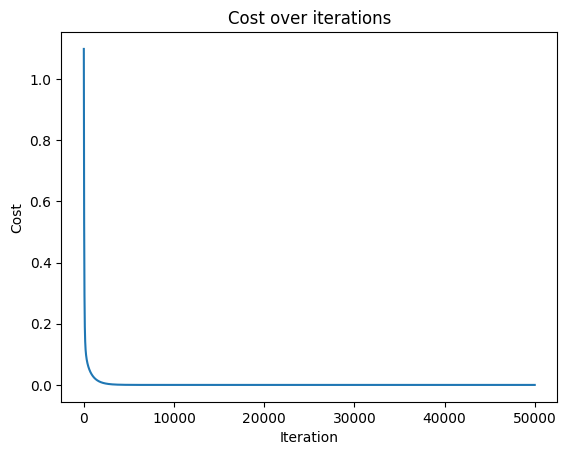

Coefficient vector x: [5.01735086e-14 1.16747011e-14 1.26772651e-14 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Mean Squared Error (MSE): 1.2643776226572552e-27


In [381]:
# generate vectors p and q
p = np.random.uniform(-1, 1, 100)
q = np.random.uniform(-1, 1, 100)

# generate the target variable b
b = p * q + p**2 + q**2

# defining the 6 basis functions
f0 = np.ones(100)
f1 = p
f2 = q
f3 = p**2
f4 = q**2
f5 = p * q

# creating matrix A from the basis functions
A = np.column_stack((f0, f1, f2, f3, f4, f5))

# gradient descent functions
# cost function
def cost(x,y,theta):
    return np.sum((x @ theta - y)**2)/(2*len(y))

# gradient descent function which updates theta
def gradient_descent(x,y,theta,learning_rate):
    return theta - learning_rate * x.T @ (x @ theta - y) / len(y)

# doing the gradient descent and plotting the cost function over iterations
# random initial theta
theta = np.random.randn(6)
# print("Initial theta:", theta)

learning_rate = 0.01
num_iterations = 50000
cost_history = np.zeros(num_iterations)

for i in range(num_iterations):
    theta = gradient_descent(A,b,theta,learning_rate)
    cost_history[i] = cost(A,b,theta)
plt.plot(cost_history)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# calculating the mse and printing the results
mse = np.mean((A @ theta - b)**2)
print("Coefficient vector x:", theta)
print("Mean Squared Error (MSE):", mse)

## Question 9

Here, based on the given data, we have to fit 3 piece wise polynomial functions on the interval [0,1] and [1,2] and [2,3] respectively for f1, f2 and f3.

It is given that f1 is degree 2 polynomial, f2 is degree 3 polynomial and f3 is degree 2 polynomial. Further, to impose continuity and differentiability at the boundaries, some additional constraints are added.

f1(1) = f2(1) and f2(2) = f3(2) and f2'(2) = f3'(2)

Now, we have to find the optimal weights vector x1, x2 and x3 for f1, f2 and f3 respectively, using the least squares method. 

We get,
f1(x) = 4.00 + -3.00x + 1.00x^2

f2(x) = 1.00 + 0.00x + -2.00x^2 + 3.00x^3

f3(x) = -35.00 + 24.00x + 1.00x^2

We see that the required polynomials also satisfy the given constraints. (Note that f1'(1) != f2'(1), but it is not our constraint.)

Finally, the data points and the fitted polynomials are plotted to see how well the polynomials fit the data, it can be seen that our polynomials fit the data very well.

Function for part 1 = 4.00 + -3.00x + 1.00x^2
Function for part 2 = 1.00 + 0.00x + -2.00x^2 + 3.00x^3
Function for part 3 = -35.00 + 24.00x + 1.00x^2

Constraints:
f1(1) = 2.00
f2(1) = 2.00
f2(2) = 17.00
f3(2) = 17.00
f2'(2) = 28.00
f3'(2) = 28.00


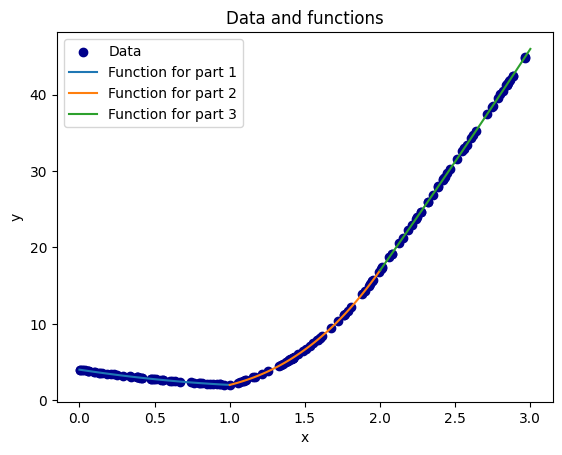

In [382]:
# loading the data
data = pd.read_csv("q9.csv")
data = data.values

# dividing the data into three parts
part_1 = data[(data[:, 0] >= 0) & (data[:, 0] <= 1)]
part_2 = data[(data[:, 0] > 1) & (data[:, 0] <= 2)]
part_3 = data[(data[:, 0] > 2) & (data[:, 0] <= 3)]

# defining the evaluation function
def f(params, x):
    return np.polyval(params, x)

# least squares function for polynomial regression which returns the parameters
def least_squares_poly(part, degree):
    x = part[:, 0]
    y = part[:, 1]
    X = np.vander(x, degree + 1)

    params = least_squares(X, y)
    return params

# calculating the parameters for the 3 parts
params_1 = least_squares_poly(part_1, 2)
params_2 = least_squares_poly(part_2, 3)
params_3 = least_squares_poly(part_3, 2)

# printing the functions
print("Function for part 1 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_1[2], params_1[1], params_1[0]))
print("Function for part 2 = {:.2f} + {:.2f}x + {:.2f}x^2 + {:.2f}x^3".format(params_2[3], params_2[2], params_2[1], params_2[0]))
print("Function for part 3 = {:.2f} + {:.2f}x + {:.2f}x^2".format(params_3[2], params_3[1], params_3[0]))

print("\nConstraints:")

# check continuity
print("f1(1) = {:.2f}".format(f(params_1, 1)))
print("f2(1) = {:.2f}".format(f(params_2, 1)))
print("f2(2) = {:.2f}".format(f(params_2, 2)))
print("f3(2) = {:.2f}".format(f(params_3, 2)))

# check differentiability
print("f2'(2) = {:.2f}".format(f(np.polyder(params_2), 2)))
print("f3'(2) = {:.2f}".format(f(np.polyder(params_3), 2)))

# plotting the data and the functions to compare
plt.scatter(data[:, 0], data[:, 1], label="Data", color="darkblue")

x = np.linspace(0, 1, 100)
plt.plot(x, f(params_1, x), label="Function for part 1")
x = np.linspace(1, 2, 100)
plt.plot(x, f(params_2, x), label="Function for part 2")
x = np.linspace(2, 3, 100)
plt.plot(x, f(params_3, x), label="Function for part 3")

plt.title("Data and functions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()